In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score, cohen_kappa_score
from functools import reduce

# Process annotated dataset

In [2]:
data = pd.read_csv('../datasets/persent_annotated/per_sent_labelled_data.csv')
data = data.iloc[:, :-32]
data.drop(columns='ASPECT-other', inplace=True)
data.sort_values(by='External ID', inplace=True, ignore_index=True)
data.head()

,ID,External ID,TRUE_SENTIMENT,ASPECT_SENTIMENT-corruption,ASPECT_SENTIMENT-crime_justice_system,ASPECT_SENTIMENT-digital_online,ASPECT_SENTIMENT-economic_issues,ASPECT_SENTIMENT-education,ASPECT_SENTIMENT-environmental,ASPECT_SENTIMENT-public_health,ASPECT_SENTIMENT-religion,ASPECT_SENTIMENT-social_inequality_human_rights,ASPECT_SENTIMENT-terrorism,ASPECT_SENTIMENT-work_occupation,ASPECT_SENTIMENT-other,ASPECT_SENTIMENT-other_not_a_social_issue
0,cl8m8og7z3f3g070hcvl09mh4,1,2.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,cl8m7lslg3bt9072fa5v78ocs,1,2.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,cl8m7jkqh3z9207xx437mbp7k,1,2.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,cl8m7po083ual07z45dgsg8gl,2,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,cl8m7odel3s4507zk4ph5bewh,2,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Decide which annotator to use

In [3]:
# check if there are duplicates
print(data.duplicated().sum())

# seperate three annotators
ind_first = list(data.groupby(by=['External ID']).head(1).index)
ind_third = list(data.groupby(by=['External ID']).tail(1).index)
ind_second = data.loc[~(data.index.isin(ind_first) | data.index.isin(ind_third))].index
doc_ids_second = list(data.iloc[ind_second]['External ID'])

data_first = data.iloc[ind_first]
ind_doc_miss = [data_first['External ID'][i] for i in ind_first if data_first['External ID'][i] not in doc_ids_second]

data_first.reset_index(inplace=True, drop=True)
data_first = data_first.iloc[:, 3:]

data_second = data.iloc[ind_second]
data_second.reset_index(inplace=True, drop=True)
num = data_second.shape[0]
for i in range(len(ind_doc_miss)):
    data_second.loc[num+i+1, 'External ID'] = ind_doc_miss[i]
data_second.fillna(-1, inplace=True)
data_second = data_second.sort_values(by='External ID', ignore_index=True)
data_second = data_second.iloc[:, 3:]

data_third = data.iloc[ind_third]
data_third.reset_index(inplace=True, drop=True)
data_third = data_third.iloc[:, 3:]


0


<ipython-input-3-28688e474b7c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_second.loc[num+i+1, 'External ID'] = ind_doc_miss[i]


In [4]:
# Calulate average inter-annotator agreement over each column for three annotators
num_cols = data_first.shape[1]

score1, score2, score3 = 0, 0, 0
for i in range(num_cols):
    temp1 = cohen_kappa_score(data_first.iloc[:,i], data_second.iloc[:,i])
    temp2 = cohen_kappa_score(data_first.iloc[:,i], data_third.iloc[:,i])
    temp3 = cohen_kappa_score(data_third.iloc[:,i], data_second.iloc[:,i])
    
    score1 += (temp1 + temp2)
    score2 += (temp1 + temp3)
    score3 += (temp2 + temp3)
    
score1 /= num_cols*2
score2 /= num_cols*2
score3 /= num_cols*2

print(score1, score2, score3)

0.9246736316312185 0.926295846356335 0.9244412984577531


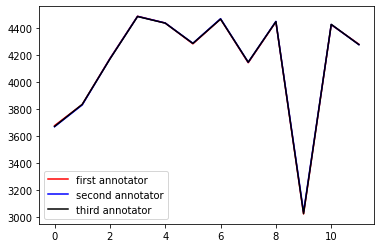

0.9210310890482014 0.9382819799216001 0.9234452200690364


In [5]:
# Check which aspect has the least number of None values
neg1, neg2, neg3 = [], [], []
for i in range(1, num_cols):
    temp1 = data_first.iloc[:,i].value_counts()
    neg1.append(temp1[-1] if -1 in temp1.index else 0)
    
    temp2 = data_second.iloc[:,i].value_counts()
    neg2.append(temp2[-1] if -1 in temp2.index else 0)
    
    temp3 = data_third.iloc[:,i].value_counts()
    neg3.append(temp3[-1] if -1 in temp3.index else 0)
    
plt.plot(neg1, color='red', label='first annotator')
plt.plot(neg2, color='blue', label='second annotator')
plt.plot(neg3, color='black', label='third annotator')

plt.legend()
plt.show()

# Select the 10th aspect
temp1 = cohen_kappa_score(data_first.iloc[:,11], data_second.iloc[:,11])
temp2 = cohen_kappa_score(data_first.iloc[:,11], data_third.iloc[:,11])
temp3 = cohen_kappa_score(data_third.iloc[:,11], data_second.iloc[:,11])
print((temp1+temp2)/2, (temp1+temp3)/2, (temp2+temp3)/2)

In [6]:
# select second annotation set
data1 = data.iloc[ind_second]
data1.reset_index(inplace=True, drop=True)
num = data1.shape[0]
for i in range(len(ind_doc_miss)):
    data1.loc[num+i+1, 'External ID'] = ind_doc_miss[i]
data1.fillna(-1, inplace=True)
data1 = data1.sort_values(by='External ID', ignore_index=True)
data1

<ipython-input-6-9c9764c55739>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.loc[num+i+1, 'External ID'] = ind_doc_miss[i]


,ID,External ID,TRUE_SENTIMENT,ASPECT_SENTIMENT-corruption,ASPECT_SENTIMENT-crime_justice_system,ASPECT_SENTIMENT-digital_online,ASPECT_SENTIMENT-economic_issues,ASPECT_SENTIMENT-education,ASPECT_SENTIMENT-environmental,ASPECT_SENTIMENT-public_health,ASPECT_SENTIMENT-religion,ASPECT_SENTIMENT-social_inequality_human_rights,ASPECT_SENTIMENT-terrorism,ASPECT_SENTIMENT-work_occupation,ASPECT_SENTIMENT-other,ASPECT_SENTIMENT-other_not_a_social_issue
0,cl8m7lslg3bt9072fa5v78ocs,1.0,2.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,cl8m7odel3s4507zk4ph5bewh,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,cl8m7o0ml2f8107y0acnc62qg,3.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,cl8m6g3t031xh070h8zldcqoc,4.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,cl8m67mzv30mb08wa8rxv5ph8,5.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4507,cl8n95djmda9r072f5dux9xk7,4524.0,2.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4508,cl8n8ulfkbkni0716hjsy0azn,4525.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0
4509,cl8m83ph042tj080y7ezqhq96,4526.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0
4510,cl8m8l1my456k07xx8c400ekp,4527.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## View data distribution regarding aspects

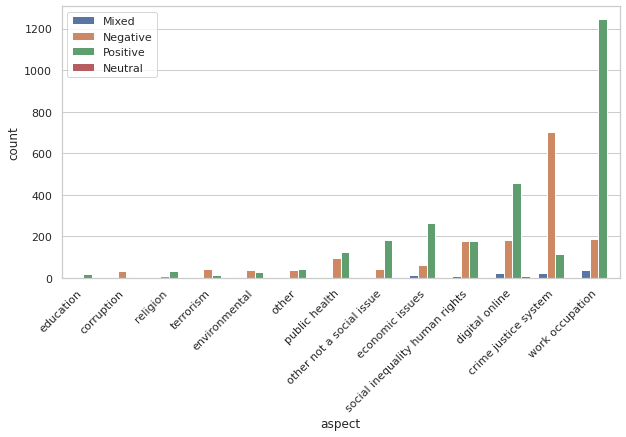

In [8]:
aspect_lst = ['corruption', 'crime justice system', 'digital online', 'economic issues', 'education', 'environmental', 'public health', 'religion', 'social inequality human rights', 'terrorism', 'work occupation', 'other', 'other not a social issue']
docs, aspects, sentiment = [], [], []
sent_map = {0:'Negative', 1:'Neutral', 2:'Positive', 3:'Mixed'}

for i in range(data1.shape[0]):
    for j in range(3, data1.shape[1]):
        if data1.iloc[i, j] != -1:
            docs.append(data1['External ID'][i])
            aspects.append(aspect_lst[j-3])
            sentiment.append(data1['TRUE_SENTIMENT'][i])

df = pd.DataFrame({'doc': docs, 'aspect': aspects, 'sentiment':sentiment})
df['sentiment'] = df['sentiment'].map(sent_map)

df_new = df.groupby(by=['aspect', 'sentiment']).count()
df_new.reset_index(inplace=True)
df_new = df_new[['aspect', 'sentiment', 'doc']]
df_new.columns = ['aspect', 'sentiment', 'count']

df_new2 = df.groupby(by=['aspect']).count()
df_new2.reset_index(inplace=True)
df_new2 = df_new2[['aspect', 'doc']]
df_new2.columns = ['aspect', 'count']
df_new2.sort_values(by=['count'], inplace=True)

fig, ax  = plt.subplots(1,1, figsize = (10,5))
sns.set_theme(style="whitegrid")
sns.barplot(x='aspect', y='count', data=df_new, hue='sentiment', order=list(df_new2.aspect))
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
ax.legend(loc='upper left')

plt.show()

# Create 4-aspect dataset

In [10]:
def aspect4_copy_generation(data_w_doc, data_w_aspect):
    labels = {-1:'None', 0:'Negative', 1:'None', 2:'Positive', 3:'Negative'}
    df = data_w_doc.iloc[:, :5]
    df = df.merge(data_w_aspect, left_on='DOCUMENT_INDEX', right_on='doc_ID')
    df.drop(columns='doc_ID', inplace=True)
    
    df1 = df[['DOCUMENT_INDEX', 'TITLE', 'TARGET_ENTITY', 'DOCUMENT', 'MASKED_DOCUMENT']]
    df1 = df1.loc[df1.index.repeat(4)]
    groups = ['work occupation', 'crime justice system', 'digital online', 'social inequality human rights'] * (df1.shape[0] // 4)

    df1['group'] = groups
    df1['sentiment'] = np.nan
    df1.reset_index(inplace=True, drop=True)

    for i in range(df.shape[0]):
        df1.loc[i*4, 'sentiment'] = df.loc[i, 'work_occupation']
        df1.loc[i*4+1, 'sentiment'] = df.loc[i, 'crime_justice_system']
        df1.loc[i*4+2, 'sentiment'] = df.loc[i, 'digital_online']
        df1.loc[i*4+3, 'sentiment'] = df.loc[i, 'social_inequality_human_rights']
    df1['context'] = '[TGT] - '+ df1['group']
    
    to_drop = []
    for j in range(df1.shape[0] // 4):
        temp = list(df1.loc[j*4:j*4+4, 'sentiment'])
        if 0 not in temp and 2 not in temp:
            to_drop.extend(range(j*4,j*4+4))
    
    df1.drop(index=to_drop, inplace=True)
    df1.reset_index(inplace=True, drop=True)
    df1['sentiment'] = df1['sentiment'].map(labels)
    
    return df1


data1_4 = data1[['External ID', 'TRUE_SENTIMENT', 'ASPECT_SENTIMENT-work_occupation', 'ASPECT_SENTIMENT-crime_justice_system', 'ASPECT_SENTIMENT-digital_online', 'ASPECT_SENTIMENT-social_inequality_human_rights']]
data1_4.columns = ['doc_ID', 'true_sentiment', 'work_occupation', 'crime_justice_system', 'digital_online', 'social_inequality_human_rights']
data1_4.head()

'''
Remember to add aspect information for all three data splits: train.csv, dev.csv, random_test.csv
Current utilized data split is train.csv
'''

data_doc = pd.read_csv('../datasets/persent/train.csv')
data4 = aspect4_copy_generation(data_doc, data1_4)
print(data4.shape)
data4.head()


(10888, 8)


,DOCUMENT_INDEX,TITLE,TARGET_ENTITY,DOCUMENT,MASKED_DOCUMENT,group,sentiment,context
0,2,8th LD Writethru: 9th passenger released from ...,Rolando Mendoza,The Philippine National Police (PNP) identifie...,The Philippine National Police (PNP) identifie...,work occupation,None,[TGT] - work occupation
1,2,8th LD Writethru: 9th passenger released from ...,Rolando Mendoza,The Philippine National Police (PNP) identifie...,The Philippine National Police (PNP) identifie...,crime justice system,Negative,[TGT] - crime justice system
2,2,8th LD Writethru: 9th passenger released from ...,Rolando Mendoza,The Philippine National Police (PNP) identifie...,The Philippine National Police (PNP) identifie...,digital online,None,[TGT] - digital online
3,2,8th LD Writethru: 9th passenger released from ...,Rolando Mendoza,The Philippine National Police (PNP) identifie...,The Philippine National Police (PNP) identifie...,social inequality human rights,None,[TGT] - social inequality human rights
4,3,Commission: Bar Liberian president from office,Charles Taylor,Sirleaf 70 acknowledged before the commissio...,Sirleaf 70 acknowledged before the commissio...,work occupation,None,[TGT] - work occupation


In [ ]:
# Remember to switch the prefix of the file name: train, dev and random_test
# Current prefix is train

data4.to_csv("../datasets/persent_annotated/train_4topics_noNeuMix.csv", index=False)

# Create 7-aspect dataset

In [28]:
def aspect7_copy_generation(data_w_doc, data_w_aspect):
    labels = {-1:'None', 0:'Negative', 1:'None', 2:'Positive', 3:'Negative'}
    df = data_w_doc.iloc[:, :5]
    df = df.merge(data_w_aspect, left_on='DOCUMENT_INDEX', right_on='doc_ID')
    df.drop(columns='doc_ID', inplace=True)
    
    df1 = df[['DOCUMENT_INDEX', 'TITLE', 'TARGET_ENTITY', 'DOCUMENT', 'MASKED_DOCUMENT']]
    df1 = df1.loc[df1.index.repeat(7)]
    groups = ['work occupation', 'crime justice system', 'digital online', 'social inequality human rights', 'economic issues', 'other not a social issue', 'public health'] * (df1.shape[0] // 7)

    df1['group'] = groups
    df1['sentiment'] = np.nan
    df1.reset_index(inplace=True, drop=True)

    for i in range(df.shape[0]):
        df1.loc[i*7, 'sentiment'] = df.loc[i, 'work_occupation']
        df1.loc[i*7+1, 'sentiment'] = df.loc[i, 'crime_justice_system']
        df1.loc[i*7+2, 'sentiment'] = df.loc[i, 'digital_online']
        df1.loc[i*7+3, 'sentiment'] = df.loc[i, 'social_inequality_human_rights']
        df1.loc[i*7+4, 'sentiment'] = df.loc[i, 'economic_issues']
        df1.loc[i*7+5, 'sentiment'] = df.loc[i, 'other_not_a_social_issue']
        df1.loc[i*7+6, 'sentiment'] = df.loc[i, 'public_health']
    df1['context'] = '[TGT] - '+ df1['group']
    to_drop = []
    for j in range(df1.shape[0] // 7):
        temp = list(df1.loc[j*7:j*7+7, 'sentiment'])
        if 0 not in temp and 2 not in temp:
            to_drop.extend(range(j*7,j*7+7))
    
    df1.drop(index=to_drop, inplace=True)
    df1.reset_index(inplace=True, drop=True)
    df1['sentiment'] = df1['sentiment'].map(labels)
    
    return df1
    
data1_7 = data1[['External ID', 'TRUE_SENTIMENT', 'ASPECT_SENTIMENT-work_occupation', 'ASPECT_SENTIMENT-crime_justice_system', 'ASPECT_SENTIMENT-digital_online', 'ASPECT_SENTIMENT-social_inequality_human_rights', 'ASPECT_SENTIMENT-economic_issues', 'ASPECT_SENTIMENT-other_not_a_social_issue', 'ASPECT_SENTIMENT-public_health']]
data1_7.columns = ['doc_ID', 'true_sentiment', 'work_occupation', 'crime_justice_system', 'digital_online', 'social_inequality_human_rights', 'economic_issues', 'other_not_a_social_issue', 'public_health']
data1_7.head()

'''
Remember to add aspect information for all three data splits: train.csv, dev.csv, random_test.csv
Current utilized data split is train.csv
'''

data_doc = pd.read_csv('../datasets/persent/train.csv')
data7 = aspect7_copy_generation(data_doc, data1_7)
print(data7.shape)
data7.head()
    
    

(21756, 8)


,DOCUMENT_INDEX,TITLE,TARGET_ENTITY,DOCUMENT,MASKED_DOCUMENT,group,sentiment,context
0,1,German bank LBBW wins EU bailout approval,Landesbank Baden Wuertemberg,Germany's Landesbank Baden Wuertemberg won EU ...,[TGT] won EU approval Tuesday for a state bail...,work occupation,None,[TGT] - work occupation
1,1,German bank LBBW wins EU bailout approval,Landesbank Baden Wuertemberg,Germany's Landesbank Baden Wuertemberg won EU ...,[TGT] won EU approval Tuesday for a state bail...,crime justice system,None,[TGT] - crime justice system
2,1,German bank LBBW wins EU bailout approval,Landesbank Baden Wuertemberg,Germany's Landesbank Baden Wuertemberg won EU ...,[TGT] won EU approval Tuesday for a state bail...,digital online,None,[TGT] - digital online
3,1,German bank LBBW wins EU bailout approval,Landesbank Baden Wuertemberg,Germany's Landesbank Baden Wuertemberg won EU ...,[TGT] won EU approval Tuesday for a state bail...,social inequality human rights,None,[TGT] - social inequality human rights
4,1,German bank LBBW wins EU bailout approval,Landesbank Baden Wuertemberg,Germany's Landesbank Baden Wuertemberg won EU ...,[TGT] won EU approval Tuesday for a state bail...,economic issues,Positive,[TGT] - economic issues


In [ ]:
# Remember to switch the prefix of the file name: train, dev and random_test
# Current prefix is train

data7.to_csv("../datasets/persent_annotated/train_7topics_noNeuMix.csv", index=False)

# Obtain annotated dataset with paragraph information

In [16]:
data = pd.read_csv('../datasets/persent_annotated/per_sent_labelled_data.csv')
# select second annotation set
ind_first = list(data.groupby(by=['External ID']).head(1).index)
ind_third = list(data.groupby(by=['External ID']).tail(1).index)
ind_second = data.loc[~(data.index.isin(ind_first) | data.index.isin(ind_third))].index
data2 = data.iloc[ind_second]
data2.reset_index(inplace=True, drop=True)
num = data2.shape[0]
for i in range(len(ind_doc_miss)):
    data2.loc[num+i+1, 'External ID'] = ind_doc_miss[i]
data2.fillna(-1, inplace=True)
data2 = data2.sort_values(by='External ID', ignore_index=True)


<ipython-input-16-0a12e92ed966>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.loc[num+i+1, 'External ID'] = ind_doc_miss[i]


# Create paragraph dataset

## 4-aspect dataset

In [29]:
def aspect4_para_generation(data_w_doc, data_w_aspect):
    labels = {0:'Negative', 1:'Neutral', 2:'Positive'}
    
    data_w_doc['paras'] = data_w_doc['MASKED_DOCUMENT'].apply(lambda x: x.split('\n'))
    df1 = data_w_aspect.merge(data_w_doc, left_on='External ID', right_on='DOCUMENT_INDEX')
    paras = list(df1['paras'])
    
    paras1, sents, aspects = [], [], []

    for i in range(df1.shape[0]):
        if len(paras[i]) > 16:
            sents.extend(df1.iloc[i, 33:49])
            aspects.extend(df1.iloc[i, 17:33])
            paras1.extend(paras[i][:16])
        else:
            sents.extend(df1.iloc[i, 33:33+len(paras[i])])
            aspects.extend(df1.iloc[i, 17:17+len(paras[i])])
            paras1.extend(paras[i])
    df2 = pd.DataFrame({'Paragraph':paras1, 'Sentiment':sents, 'Aspects':aspects})                            
    df2['Word_Count'] = df2['Paragraph'].apply(lambda x: len(x.split()))
    df2['Contains_Target'] = df2['Paragraph'].apply(lambda x: '[TGT]' in x)
    df2 = df2.loc[(df2['Word_Count']<=128) & (df2['Contains_Target']) & (df2['Sentiment']!=1)]
    df2.reset_index(inplace=True, drop=True)
    df2['Sentiment'] = df2['Sentiment'].map(labels)
    df2['Aspects'] = df2['Aspects'].astype(str)
    df2.drop(columns=['Word_Count', 'Contains_Target'], inplace=True)
    
    to_include = ['work_occupation', 'crime_justice_system', 'digital_online', 'social_inequality_human_rights']
    df2 = df2.loc[df2['Aspects'].isin(to_include)]
    df2.dropna(inplace=True)
    df2.reset_index(inplace=True, drop=True)
    df2['Aspects'] = df2['Aspects'].str.replace('_', ' ')
    
    df3 = df2.loc[df2.index.repeat(4)]
    df3.reset_index(inplace=True, drop=True)
    groups = ['work occupation', 'crime justice system', 'digital online', 'social inequality human rights'] * (df3.shape[0] // 4)
    df3['Aspects'] = groups
    
    for j in range(df2.shape[0]):
        for k in range(4):
            if df3['Aspects'][j*4+k] != df2['Aspects'][j]:
                df3.loc[j*4+k, 'Sentiment'] = 'None'
    df3['Context'] = '[TGT] - '+ df3['Aspects']
    
    return df3

'''
Remember to add aspect information for all three data splits: train.csv, dev.csv, random_test.csv
Current utilized data split is train.csv
'''

df_doc = pd.read_csv('../datasets/persent/train.csv')
df_para4 = aspect4_para_generation(df_doc, data2)



In [ ]:
# Remember to switch the prefix of the file name: train, dev and random_test
# Current prefix is train

df_para4.to_csv("../datasets/persent_annotated/train_para_4topics_noNeuMix.csv", index=False)

## 7-aspect dataset

In [30]:
def aspect7_para_generation(data_w_doc, data_w_aspect):
    labels = {0:'Negative', 1:'Neutral', 2:'Positive'}
    
    data_w_doc['paras'] = data_w_doc['MASKED_DOCUMENT'].apply(lambda x: x.split('\n'))
    df1 = data_w_aspect.merge(data_w_doc, left_on='External ID', right_on='DOCUMENT_INDEX')
    paras = list(df1['paras'])
    
    paras1, sents, aspects = [], [], []

    for i in range(df1.shape[0]):
        if len(paras[i]) > 16:
            sents.extend(df1.iloc[i, 33:49])
            aspects.extend(df1.iloc[i, 17:33])
            paras1.extend(paras[i][:16])
        else:
            sents.extend(df1.iloc[i, 33:33+len(paras[i])])
            aspects.extend(df1.iloc[i, 17:17+len(paras[i])])
            paras1.extend(paras[i])
    df2 = pd.DataFrame({'Paragraph':paras1, 'Sentiment':sents, 'Aspects':aspects})                            
    df2['Word_Count'] = df2['Paragraph'].apply(lambda x: len(x.split()))
    df2['Contains_Target'] = df2['Paragraph'].apply(lambda x: '[TGT]' in x)
    df2 = df2.loc[(df2['Word_Count']<=128) & (df2['Contains_Target']) & (df2['Sentiment']!=1)]
    df2.reset_index(inplace=True, drop=True)
    df2['Sentiment'] = df2['Sentiment'].map(labels)
    df2['Aspects'] = df2['Aspects'].astype(str)
    df2.drop(columns=['Word_Count', 'Contains_Target'], inplace=True)
    
    to_include = ['work_occupation', 'crime_justice_system', 'digital_online', 'social_inequality_human_rights', 'economic_issues', 'other_not_a_social_issue', 'public_health_health_conditions_infections']
    df2 = df2.loc[df2['Aspects'].isin(to_include)]
    df2.dropna(inplace=True)
    df2.reset_index(inplace=True, drop=True)
    df2['Aspects'] = df2['Aspects'].apply(lambda x: 'public health' if x == 'public_health_health_conditions_infections' else x)
    df2['Aspects'] = df2['Aspects'].str.replace('_', ' ')
    
    df3 = df2.loc[df2.index.repeat(7)]
    df3.reset_index(inplace=True, drop=True)
    groups = ['work occupation', 'crime justice system', 'digital online', 'social inequality human rights', 'economic issues', 'other not a social issue', 'public health'] * (df3.shape[0] // 7)    
    df3['Aspects'] = groups
    
    for j in range(df2.shape[0]):
        for k in range(7):
            if df3['Aspects'][j*7+k] != df2['Aspects'][j]:
                df3.loc[j*7+k, 'Sentiment'] = 'None'
    df3['Context'] = '[TGT] - '+ df3['Aspects']
    
    return df3

'''
Remember to add aspect information for all three data splits: train.csv, dev.csv, random_test.csv
Current utilized data split is train.csv
'''

df_doc = pd.read_csv('../datasets/persent/train.csv')
df_para7 = aspect7_para_generation(df_doc, data2)



In [ ]:
# Remember to switch the prefix of the file name: train, dev and random_test
# Current prefix is train

df_para7.to_csv("../datasets/persent_annotated/train_para_7topics_noNeuMix.csv", index=False)

# Create dataset for pure Longformer model

In [26]:
def aspect4_longformer_generation(data):
    df1 = data.loc[data.index.repeat(3)]

    labels = ['None', 'Negative', 'Positive']
    label_map = dict(zip(labels, range(3)))

    df1['sentiment'] = labels * (df1.shape[0] // 3)
    df1['label'] = np.nan
    df1.reset_index(inplace=True, drop=True)

    for i in range(data.shape[0]):
        temp_label = label_map[data.loc[i, 'sentiment']]
        df1.loc[i * 3 + temp_label, 'label'] = 1
        
    df1['label'].fillna(0, inplace=True)
    df1['auxi_sent'] = 'the polarity of the aspect ' + df1['group'] + ' of [TGT] is ' + df1['sentiment'] + '.'
    return df1

def aspect7_longformer_generation(data):

    df1 = data.loc[data.index.repeat(3)]

    labels = ['None', 'Negative', 'Positive']
    label_map = dict(zip(labels, range(3)))

    df1['sentiment'] = labels * (df1.shape[0] // 3)
    df1['label'] = np.nan
    df1.reset_index(inplace=True, drop=True)

    for i in range(data.shape[0]):
        temp_label = label_map[data.loc[i, 'sentiment']]
        df1.loc[i * 3 + temp_label, 'label'] = 1
        
    df1['label'].fillna(0, inplace=True)
    df1['auxi_sent'] = 'the polarity of the aspect ' + df1['group'] + ' of [TGT] is ' + df1['sentiment'] + '.'
    return df1

In [27]:
'''
Remember to add aspect information for all three data splits: train.csv, dev.csv, random_test.csv
Current utilized data split is train.csv
'''

df4 = pd.read_csv("../datasets/persent_annotated/train_longformer_4topics_auxiliary_noNeuMix.csv")
df7 = pd.read_csv("../datasets/persent_annotated/train_longformer_7topics_auxiliary_noNeuMix.csv")


df_long4 = aspect4_longformer_generation(df4)
df_long7 = aspect7_longformer_generation(df7)


In [ ]:
# Remember to switch the prefix of the file name: train, dev and random_test
# Current prefix is train

df_long4.to_csv("../datasets/persent_annotated/train_longformer_4topics_auxiliary_noNeuMix.csv", index=False)
df_long7.to_csv("../datasets/persent_annotated/train_longformer_7topics_auxiliary_noNeuMix.csv", index=False)